# Handwritten Classification with Tensor Learning

In this notebook we will see how to use tensor techniques to solve a classic machine learning problem: the handwritten classification problem. The module *Tensor Fox* is a tensor library I did for my Phd thesis, you can learn more about it [here](https://github.com/felipebottega/TensorFox). For more information about the techniques used here I recommend the article *Handwritten digit classification using higher order singular value decomposition*, from B. Savas and L. Eldén.

We are given a train dataset consituted of $42000$ images of size $28 \times 28$, which is then transformed in a tensor $28 \times 28 \times 42000$ such that each slice is a $28 \times 28$ image of one of the digits $d = 0, 1, \ldots, 9$. We have a total of $42000$ samples to work with. We also are given the labels of each image. Let's begin importing the relevant modules and creating the relevant arrays.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import TensorLearning as tl
import TensorFox as tfx

In [2]:
# PREPROCESSING

# Train dataset.
data = pd.read_csv('train.csv')
data_array = data.values

num_samples, n = data_array.shape[0], data_array.shape[1] - 1

X = np.zeros((num_samples, n))
Y = np.zeros(num_samples)

for i in range(num_samples):
    X[i, :] = data_array[i, 1:]
    Y[i] = data_array[i, 0]
    
Y = np.array(Y, dtype=np.int64)

# Test dataset.
data = pd.read_csv('test.csv')
X_test = data.values

# Normalize data.
X, mu, sigma = tl.normalization(X, method='mean_normalization')

# Creating a tensor from the data

Let $X \in \mathbb{R}^{N \times n}$ be the train data, where each row of $X$ is a single input data. We have a total of $N$ inputs of dimension $n$. If there are a total of $p$ classes in the data, the function *data2tens* creates a tensor $T \in \mathbb{R}^{m \times n \times p}$, where $m$ in the number of inputs in each class. In the case the number of inputs per class disagree, the function can add repeated inputs in a class to match the other, so it is possible to have $m p > N$.

Inputs of class 0 = 4132
Inputs of class 1 = 4684
Inputs of class 2 = 4177
Inputs of class 3 = 4351
Inputs of class 4 = 4072
Inputs of class 5 = 3795
Inputs of class 6 = 4137
Inputs of class 7 = 4401
Inputs of class 8 = 4063
Inputs of class 9 = 4188

After fixing number of inputs per class:
Inputs of class 0 = 4684
Inputs of class 1 = 4684
Inputs of class 2 = 4684
Inputs of class 3 = 4684
Inputs of class 4 = 4684
Inputs of class 5 = 4684
Inputs of class 6 = 4684
Inputs of class 7 = 4684
Inputs of class 8 = 4684
Inputs of class 9 = 4684

T.shape = (4684, 784, 10)



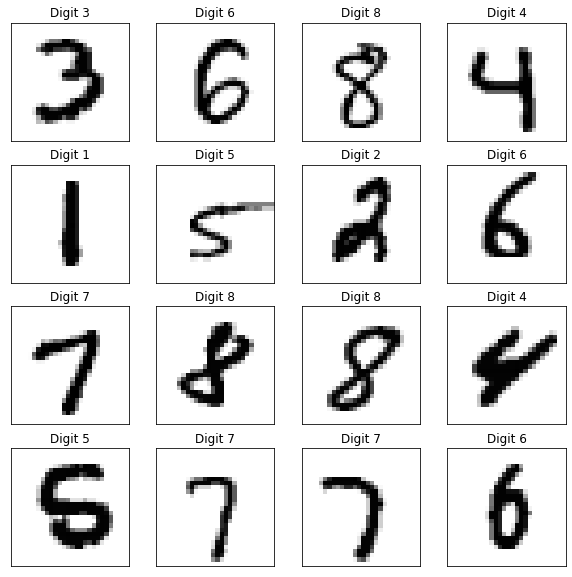

In [3]:
# TRANSFORM DATA INTO TENSOR

# If display is True, the program shows the number of inputs per class before and after the run.
# After the function all classes have the same number of inputs, and the inputs of each class are
# joined together to form a slice of T. In this case all classes have same number of inputs.
T = tl.data2tens(X, Y, display=True)
print()
print('T.shape =', T.shape)
print()

# Below we plot some slices to visualize what kind of images we are dealing with.
num_rows = 4
num_cols = 4    
fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 10), sharex='col', sharey='row')     
for i in range(num_rows):
    for j in range(num_cols):
        element = np.random.randint(0, 20)
        element_class = np.random.randint(0,10)
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        ax[i, j].title.set_text('Digit ' + str(element_class))
        ax[i, j].imshow(-T[element, :, element_class].reshape(28, 28), cmap='gray')

# MLSVD (Multilinear Singular Value Decomposition)

For any tensor $T \in \mathbb{R}^{m \times n \times p}$, there are orthogonal matrices $U_1 \in \mathbb{R}^{m \times m}, U_2 \in \mathbb{R}^{n \times n}, U_3 \in \mathbb{R}^{p \times p}$ and a tensor $S \in \mathbb{R}^{m \times n \times p}$ such that

$$ T = (U_1, U_2, U_3) \cdot S.$$

$(U_1, U_2, U_3) \cdot S$ is the multilinear multiplication between $U_1, U_2, U_3$ and $S$. A nice feature of this decomposition is that the *energy* of $S$ is concentrated around the first coordinate, i.e., around $S[0,0,0]$. This concentration make it possible to truncate $S$ and still have a reasonable approximation, similarly when one truncate the SVD of a matrix. 

When a truncation occurs, we work with the tensor $(U_1[:, :R_1], U_2[:, :R_2], U_3[:, ;R_3]) \cdot S[:R_1, :R_2, :R_3]$. We will still use the notation $U_1, U_2, U_3, S$ for the truncation versions of these arrays.

Now consider the $R1 \times R_2 \times R_3$ tensor $F = (I_{R_1}, I_{R_2}, U_3)\cdot S \approx (U_1^T, U_2^T, I_{R_3})\cdot T$. We will consider $F$ as the compressed version of $T$. For each new image digit $z \in \mathbb{R}^n$ (remember that $n = 400$), convert it to the $R_2$ dimensional space using the transformation $z_{new} = U_2^T \cdot z$, where $U_2 \in \mathbb{R}^{n \times R_2}$. In this space we compare it to the space generated by the columns of each slice of $F$ (remember that each slice correspond to a class). The best match will be the new class. This stage of comparing is not made using the slice directly, but instead we compute the SVD of the slice and truncate it. The procedure is summarized below.

> 1) New input: $z \in \mathbb{R}^n$
   
> 2) Transform input: $z_{new} = U_2^T \cdot z \in \mathbb{R}^{R_2}$

> 3) Compute SVD of slices: $F[:,:,d] = \mathcal{U}_d \Sigma_d \mathcal{V}_d^T$ for $d = 0, \ldots 9$ 

> 4) Truncate $\mathcal{V}_d$ to have $trunc < R_1$ rows: $\tilde{\mathcal{V}}_d = \mathcal{V}_d[:trunc, :]$ 

> 5) Solve least squares problems: $\min_x \| \tilde{\mathcal{V}}_d \cdot x - z_{new} \|$ for $d = 0, \ldots, 9$

> 6) The class $d$ associated with the smallest norm is chosen to be the class of $z$

Note that, since the columns of $\tilde{\mathcal{V}}_d$ are orthonormal, the solution of the least squares problem is given by

$$x^\ast = \tilde{\mathcal{V}}_d^T \cdot z_{new}.$$

In [4]:
# TRAINING

# The MLSVD function needs a estimate of the rank of T. We can test several ranks and see how are their
# corresponding predictions. Below we show how the model performs for R=200.

R = 200
class options:
    display = 3
F, U2, success = tl.mlsvd_train(T, R, options)
print('F.shape =', F.shape)
print('U2.shape =', U2.shape)
print('success =', success)

Training model...
Shape of MLSVD: (200, 200, 10)
Error: 0.39079056463237827
Working with 1.0892 % of the original size

F.shape = (200, 200, 10)
U2.shape = (784, 200)
success = True


In [5]:
# Other alternative is to choose the truncation (shape of the MLSVD above) manually. 
# R1 (number of inputs) and R3 (number of classes) we keep fixed, only changing R2 (size of inputs).

trunc_dims_list = [[4684, R2, 10] for R2 in np.arange(150, 601, 50)]
trunc_error = tfx.cmpr.test_truncation(T, trunc_dims_list)

Truncation: [4684, 150, 10]
Error: 0.19155519336906215

Truncation: [4684, 200, 10]
Error: 0.15435911451265222

Truncation: [4684, 250, 10]
Error: 0.12469002507470722

Truncation: [4684, 300, 10]
Error: 0.09889796129613247

Truncation: [4684, 350, 10]
Error: 0.07562162422257052

Truncation: [4684, 400, 10]
Error: 0.05451151824157802

Truncation: [4684, 450, 10]
Error: 0.03686138956801874

Truncation: [4684, 500, 10]
Error: 0.023135551507413334

Truncation: [4684, 550, 10]
Error: 0.012825511714873778

Truncation: [4684, 600, 10]
Error: 0.0059633224250398385



In [6]:
# From above we note that R2 = 350 seems to be a good choice. Since we don't want to change the first 
# coordinate, we must set R = 4684 (remember that the central tensor of the MLSVD has shape (R1, R2, R3), 
# where that R1 <= min(4684, R), so we can't make R less than the number of inputs). 

R = 4684
R2 = 350

class options:
    display = 3
    trunc_dims = [4684, R2, 10]
    
F, U2, success = tl.mlsvd_train(T, R, options)

print('F.shape =', F.shape)
print('U2.shape =', U2.shape)
print('success =', success)

Training model...
Shape of MLSVD: (4684, 350, 10)
Error: 0.07562162529650628
Working with 44.6429 % of the original size

F.shape = (4684, 350, 10)
U2.shape = (784, 350)
success = True


Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished
Computing predictions...
Finished


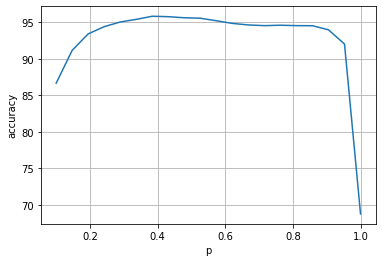

p = 0.3838947368421053
accuracy = 95.8047619047619 %


In [7]:
# TESTING

# After the model is trained, we start the step 4 described previously. The truncation of each Vd depends on
# the choice of energy we want to use. In short, the parameter p is a values between 0 and 1, where 0 means 0% 
# of the energy is retained and 1 means 100% of the energy is retained. See the function 'mlsvd_test' for more
# details.

values = np.linspace(0.1, 0.999, 20)
accuracies = np.zeros((len(values), 2))

i = 0
for p in values:
    accuracy = tl.mlsvd_test(X, Y, F, U2, p)
    accuracies[i, 0] = p
    accuracies[i, 1] = accuracy
    i += 1
    
plt.plot(values, accuracies[:, 1])
plt.grid()
plt.xlabel('p')
plt.ylabel('accuracy')
plt.show()

# Display the value p for which max accuracy is attained.
idx = np.argmax(accuracies[:, 1])
print('p =', accuracies[idx, 0])
print('accuracy =', accuracies[idx, 1], '%')

In [8]:
# Make predictions and save them in a csv file.
p = 0.3838947368421053
predictions = tl.mlsvd_predictions(X_test, F, U2, p, mu=mu, sigma=sigma)
submission = pd.read_csv('sample_submission.csv')
submission["Label"] = predictions
submission.to_csv('mlsvd_submission.csv', index=False)
print(submission.head())

Computing predictions...
Finished
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3


With this approach we could achieve a score of $0.957$ ($95.7 \%$ of accuracy) in the Kaggle's competition [digit recognizer](https://www.kaggle.com/c/digit-recognizer).